In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import numpy as np


In [2]:
data = pd.read_csv("data/HIV.csv")

In [3]:
data['HIV_active'].value_counts()

HIV_active
0    39684
1     1443
Name: count, dtype: int64

In [4]:
from rdkit.Chem import PandasTools

PandasTools.AddMoleculeColumnToFrame(data, smilesCol='smiles', molCol='Molecule')
data.head()

[08:00:43] Explicit valence for atom # 3 Al, 6, is greater than permitted
[08:00:43] Explicit valence for atom # 5 B, 5, is greater than permitted
[08:00:45] Explicit valence for atom # 16 Al, 9, is greater than permitted
[08:00:46] Explicit valence for atom # 4 Al, 9, is greater than permitted
[08:00:48] Explicit valence for atom # 12 Al, 7, is greater than permitted
[08:00:48] Explicit valence for atom # 13 Al, 7, is greater than permitted
[08:00:48] WARNING: not removing hydrogen atom without neighbors
[08:00:48] WARNING: not removing hydrogen atom without neighbors
[08:00:49] Explicit valence for atom # 6 Ge, 5, is greater than permitted


,smiles,activity,HIV_active,Molecule
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x12999fa00>
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,0,<rdkit.Chem.rdchem.Mol object at 0x1299bc200>
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,0,<rdkit.Chem.rdchem.Mol object at 0x1299bc270>
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,0,<rdkit.Chem.rdchem.Mol object at 0x1299bec70>
4,O=S(=O)(O)CCS(=O)(=O)O,CI,0,<rdkit.Chem.rdchem.Mol object at 0x1299bece0>


In [5]:
from rdkit.Chem import Descriptors
print(len(Descriptors._descList))
print(Descriptors._descList[:5])

217
[('MaxAbsEStateIndex', <function MaxAbsEStateIndex at 0x12baf94e0>), ('MaxEStateIndex', <function MaxEStateIndex at 0x12baf93a0>), ('MinAbsEStateIndex', <function MinAbsEStateIndex at 0x12baf9580>), ('MinEStateIndex', <function MinEStateIndex at 0x12baf9440>), ('qed', <function qed at 0x12baec720>)]


In [6]:
def getMolDescriptors(mol, missingVal=None):
    ''' calculate the full list of descriptors for a molecule
    
        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res
        

In [7]:
getMolDescriptors(data['Molecule'][0])

{'MaxAbsEStateIndex': np.float64(5.925902777777779),
 'MaxEStateIndex': np.float64(5.925902777777779),
 'MinAbsEStateIndex': np.float64(0.759994212962963),
 'MinEStateIndex': np.float64(-2.3300115740740743),
 'qed': 0.4343577626448334,
 'SPS': 23.36842105263158,
 'MolWt': 319.8880000000001,
 'HeavyAtomMolWt': 295.696,
 'ExactMolWt': 319.09650816808994,
 'NumValenceElectrons': 114,
 'NumRadicalElectrons': 0,
 'MaxPartialCharge': nan,
 'MinPartialCharge': nan,
 'MaxAbsPartialCharge': nan,
 'MinAbsPartialCharge': nan,
 'FpDensityMorgan1': 0.631578947368421,
 'FpDensityMorgan2': 0.8947368421052632,
 'FpDensityMorgan3': 1.105263157894737,
 'BCUT2D_MWHI': nan,
 'BCUT2D_MWLOW': nan,
 'BCUT2D_CHGHI': nan,
 'BCUT2D_CHGLO': nan,
 'BCUT2D_LOGPHI': nan,
 'BCUT2D_LOGPLOW': nan,
 'BCUT2D_MRHI': nan,
 'BCUT2D_MRLOW': nan,
 'AvgIpc': 2.45192843933087,
 'BalabanJ': np.float64(2.470867093556556),
 'BertzCT': 386.3278612823769,
 'Chi0': np.float64(13.880468888623982),
 'Chi0n': 12.177145193552503,
 'Chi0

In [9]:
_data = data
features = [getMolDescriptors(mol) for mol in _data['Molecule']]

Traceback (most recent call last):
  File "/var/folders/bc/220rhkcd2wl94b7fjf0_hg7m0000gn/T/ipykernel_12840/1701456255.py", line 10, in getMolDescriptors
    val = fn(mol)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 91, in MaxAbsEStateIndex
    return max(abs(x) for x in EStateIndices(mol, force))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 47, in EStateIndices
    nAtoms = mol.GetNumAtoms()
AttributeError: 'NoneType' object has no attribute 'GetNumAtoms'
Traceback (most recent call last):
  File "/var/folders/bc/220rhkcd2wl94b7fjf0_hg7m0000gn/T/ipykernel_12840/1701456255.py", line 10, in getMolDescriptors
    val = fn(mol)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/rdkit/Chem/EState/EState.py", line 77, in MaxEStateIndex
    return max(EStateIndices(mol, force))
  File "/Library/Framew

In [8]:
featured_df = pd.DataFrame(features)
featured_df['y'] = _data['HIV_active'].values
featured_df.head()

NameError: name 'features' is not defined

In [12]:
featured_df.to_csv('data/HIV_descriptors.csv', index=False)

In [9]:
featured_df = pd.read_csv('data/HIV_descriptors.csv')

In [10]:
# drop columns with missing values
featured_df = featured_df.dropna(axis=0)
featured_df.shape
y = featured_df['y']
X = featured_df.drop(columns=['y'])

In [11]:
y.value_counts()

y
0    38196
1     1260
Name: count, dtype: int64

In [12]:
X

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2,12.177015,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,278.271,291.071785,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.401803,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,356.296,370.029328,128.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.857917,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,184.150,189.960580,62.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.095257,12.095257,0.310361,-3.269722,0.790087,11.437500,263.661,248.541,263.047808,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.261759,10.261759,0.067130,-1.112870,0.610259,9.200000,138.122,132.074,138.031694,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,13.370142,13.370142,0.007185,-0.366239,0.804191,32.035714,379.504,350.272,379.225977,148.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41123,14.160262,14.160262,0.075082,-0.480928,0.427745,28.888889,484.596,452.340,484.236208,186.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41124,13.962959,13.962959,0.011372,-0.415582,0.450949,29.212121,440.587,408.331,440.246378,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41125,13.989331,13.989331,0.009754,-0.416314,0.450949,29.212121,440.587,408.331,440.246378,170.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
y

2        0
3        0
4        0
5        0
6        0
        ..
41122    0
41123    0
41124    0
41125    0
41126    0
Name: y, Length: 39456, dtype: int64

In [12]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.0)
selector.fit(X)
columns = selector.get_support(indices=True)
X = X.iloc[:,columns]

In [13]:
# calculate correlation value of each pair of features
corr_matrix = X.corr()


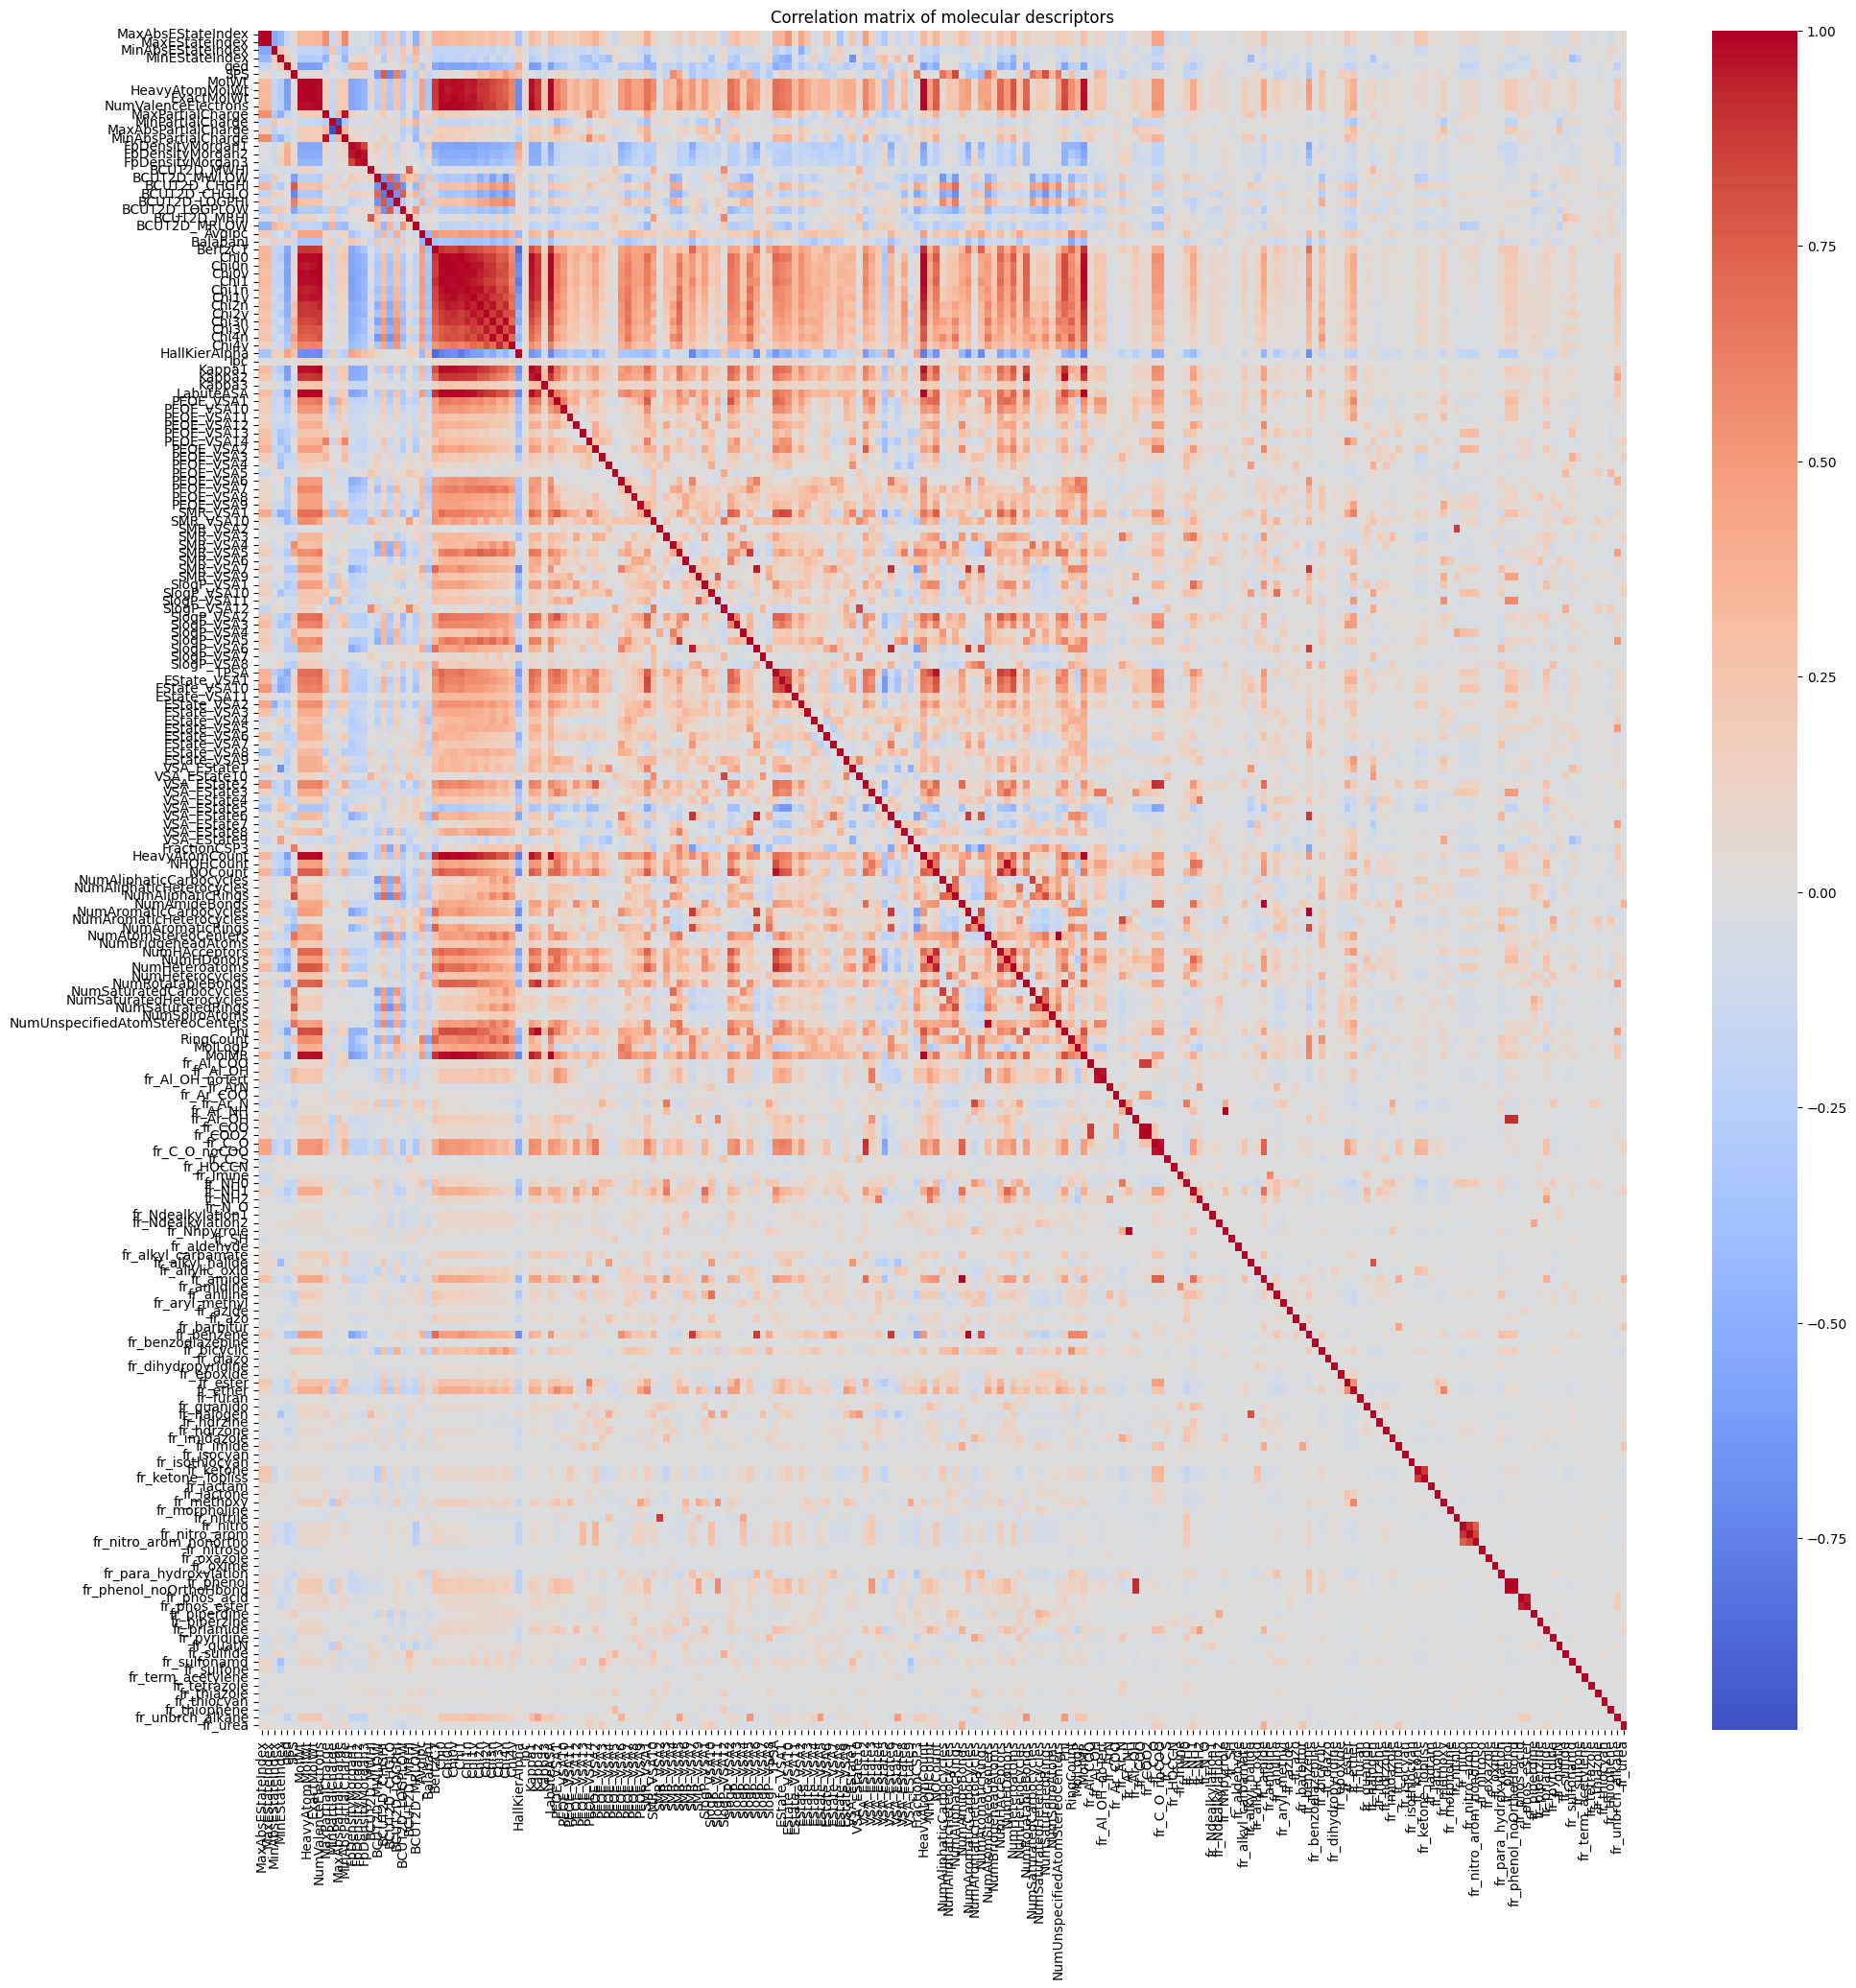

In [14]:
# make a heatmap of the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(23,23))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, xticklabels=X.columns, yticklabels=X.columns)
plt.title('Correlation matrix of molecular descriptors')
plt.show()

In [15]:
# Remove highly correlated features
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column].abs() > 0.8)]


In [17]:
upper_tri

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
MaxAbsEStateIndex,NaN,1.0,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,...,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MaxEStateIndex,NaN,NaN,-0.542781,-0.432065,-0.159450,0.065250,0.319553,0.324507,0.319849,0.337772,...,-0.092810,0.113268,0.069821,-0.002035,-0.047160,0.005268,-0.006722,-0.081215,-0.006264,0.073570
MinAbsEStateIndex,NaN,NaN,NaN,0.199459,0.068379,-0.086184,-0.173699,-0.174157,-0.173767,-0.184460,...,0.092415,-0.078126,-0.034146,-0.002925,0.021985,0.012624,0.010806,0.109916,0.010361,-0.001790
MinEStateIndex,NaN,NaN,NaN,NaN,0.198973,-0.019951,-0.267154,-0.277104,-0.267312,-0.251570,...,0.100908,-0.379926,-0.244031,0.006815,0.022561,0.036800,0.010155,0.061444,-0.030574,-0.033427
qed,NaN,NaN,NaN,NaN,NaN,0.084702,-0.602383,-0.605064,-0.602443,-0.586322,...,-0.011351,-0.048166,0.035709,-0.026206,0.003365,-0.060546,-0.001052,0.023662,-0.224896,-0.021849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fr_thiazole,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.003787,-0.013867,-0.021387,-0.012261
fr_thiocyan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000630,0.000461,-0.000272
fr_thiophene,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006187,-0.017069
fr_unbrch_alkane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001604


In [18]:
to_drop

['MaxEStateIndex',
 'HeavyAtomMolWt',
 'ExactMolWt',
 'NumValenceElectrons',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'BertzCT',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'HallKierAlpha',
 'Kappa1',
 'Kappa2',
 'LabuteASA',
 'SlogP_VSA5',
 'SlogP_VSA6',
 'EState_VSA1',
 'EState_VSA10',
 'VSA_EState10',
 'VSA_EState6',
 'HeavyAtomCount',
 'NOCount',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRotatableBonds',
 'NumSaturatedCarbocycles',
 'NumSaturatedRings',
 'NumUnspecifiedAtomStereoCenters',
 'Phi',
 'MolMR',
 'fr_Al_OH_noTert',
 'fr_Ar_N',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_Nhpyrrole',
 'fr_amide',
 'fr_benzene',
 'fr_ketone_Topliss',
 'fr_nitrile',
 'fr_nitro_arom',
 'fr_nitro_arom_nonortho',
 'fr_phenol',
 'fr_phenol_noOrthoHbond',
 'fr_phos_ester']

In [16]:
# drop the highly correlated features
X = X.drop(columns=to_drop)

In [17]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,Ipc,Kappa3,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,...,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitro,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phos_acid,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
2,12.177015,0.041001,0.041001,0.581359,12.904762,291.375,0.227991,-0.278994,0.904762,32.166581,10.085465,2.265088,-2.305509,2.500915,-2.252105,7.995965,-0.115439,2.518550,2.051191,1.113048e+05,1.850086,0.000000,0.000000,0.000000,5.907180,0.000000,0.000000,9.694447,0.000000,0.000000,0.0,54.226454,28.971550,16.714704,11.374773,4.794537,39.816286,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,11.401803,0.087790,-4.524487,0.357615,12.583333,370.408,0.294690,-0.398692,0.708333,32.241217,10.114378,2.161662,-2.060790,2.241600,-2.028340,7.857715,0.480421,2.446346,2.586774,1.145208e+05,4.113674,11.467335,9.790967,0.000000,0.000000,20.236254,0.000000,9.105500,0.000000,16.835594,0.0,24.284774,35.392371,11.374773,0.000000,25.941094,43.763066,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.857917,0.980324,-4.296481,0.538723,13.400000,190.198,0.265456,-0.285515,0.800000,32.243582,10.962804,2.109469,-1.917374,1.864461,-2.147724,7.891386,0.471615,1.573012,4.047792,6.449349e+01,7.820000,0.000000,0.000000,0.000000,0.000000,20.236254,0.000000,9.105500,0.000000,16.835594,0.0,0.000000,0.000000,0.000000,11.505707,25.941094,20.236254,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,12.095257,0.310361,-3.269722,0.790087,11.437500,263.661,0.432193,-0.292838,1.312500,35.495691,10.319023,2.228263,-2.180271,2.472861,-2.043135,7.550181,0.224732,2.171946,2.788747,3.088507e+03,4.142492,0.000000,0.000000,0.000000,0.000000,0.000000,7.746488,14.134789,4.565048,0.000000,0.0,17.667307,32.046576,10.710020,13.213764,13.612543,25.034815,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,10.261759,0.067130,-1.112870,0.610259,9.200000,138.122,0.338969,-0.507053,1.300000,16.367670,10.187505,2.051200,-1.945616,2.138185,-1.945909,5.900329,0.069352,1.878745,3.152941,1.822382e+02,1.074894,10.213055,11.312963,0.000000,0.000000,0.000000,5.969305,0.000000,4.794537,0.000000,0.0,12.132734,12.132734,0.000000,0.000000,15.007592,5.969305,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41122,13.370142,0.007185,-0.366239,0.804191,32.035714,379.504,0.253334,-0.357464,1.178571

In [18]:
# normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [16]:
X

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.384700,-0.625915,0.729836,0.277579,-0.527913,-0.436011,-0.432308,1.273904,-0.524627,0.286732,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
1,0.090784,-0.428024,-2.488228,-0.747159,-0.560540,0.041172,0.282648,0.161348,-1.214944,0.291132,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
2,-0.494572,3.346938,-2.327515,0.082308,-0.477643,-1.046894,-0.030714,1.213288,-0.892796,0.291271,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
3,0.353702,0.513337,-1.603785,1.233542,-0.676849,-0.603342,1.756557,1.145231,0.908304,0.482999,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
4,-0.341457,-0.515405,-0.083490,0.409936,-0.903969,-1.361317,0.757280,-0.845829,0.864375,-0.644691,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,0.837068,-0.768938,0.442786,1.298135,1.413999,0.096091,-0.160654,0.544551,0.437633,-0.654825,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39452,1.136637,-0.481769,0.361945,-0.425966,1.094576,0.730612,-0.269706,-0.348937,-0.287549,-0.625288,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39453,1.061831,-0.751231,0.408006,-0.319694,1.127386,0.464896,-0.269729,0.544543,-0.402918,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422
39454,1.071829,-0.758073,0.407490,-0.319694,1.127386,0.464896,-0.269727,0.544543,-0.296423,-0.655636,...,-0.25988,-0.180771,-0.124774,-0.055266,-0.050295,-0.166036,-0.022807,-0.133933,-0.154826,-0.167422


# PCA analysis

In [141]:
# fit a PCA model
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(balanced_df[['NHOHCount', 'PEOE_VSA10', 'fr_SH', 'BCUT2D_MRHI', 'SlogP_VSA2',
       'fr_Ar_NH']])

print(pca.explained_variance_ratio_)

[0.36124954 0.21025949]


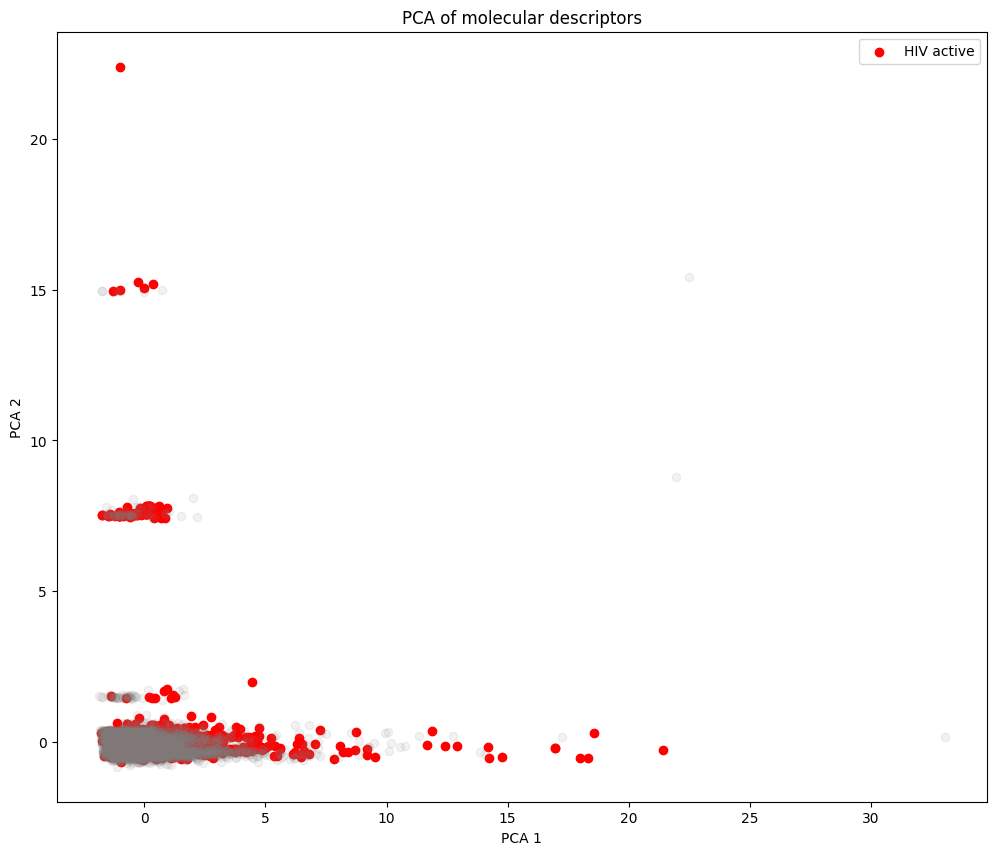

In [142]:
# plot the PCA result and color by the activity of each data point
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
# use class 1 only
X_pca_pos = X_pca[balanced_df['HIV active']==1]
X_pca_neg = X_pca[balanced_df['HIV active']==0]
plt.scatter(X_pca_pos[:,0], X_pca_pos[:,1], alpha= 1, c='red', label='HIV active')
plt.scatter(X_pca_neg[:,0], X_pca_neg[:,1], c='grey', alpha=0.1)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.title('PCA of molecular descriptors')
plt.show()

In [143]:
# umap
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.2, random_state=42)
X_umap = reducer.fit_transform(balanced_df[['NHOHCount', 'PEOE_VSA10', 'fr_SH', 'BCUT2D_MRHI', 'SlogP_VSA2',
       'fr_Ar_NH']])   

/Users/julian/opt/anaconda3/envs/r_bio/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


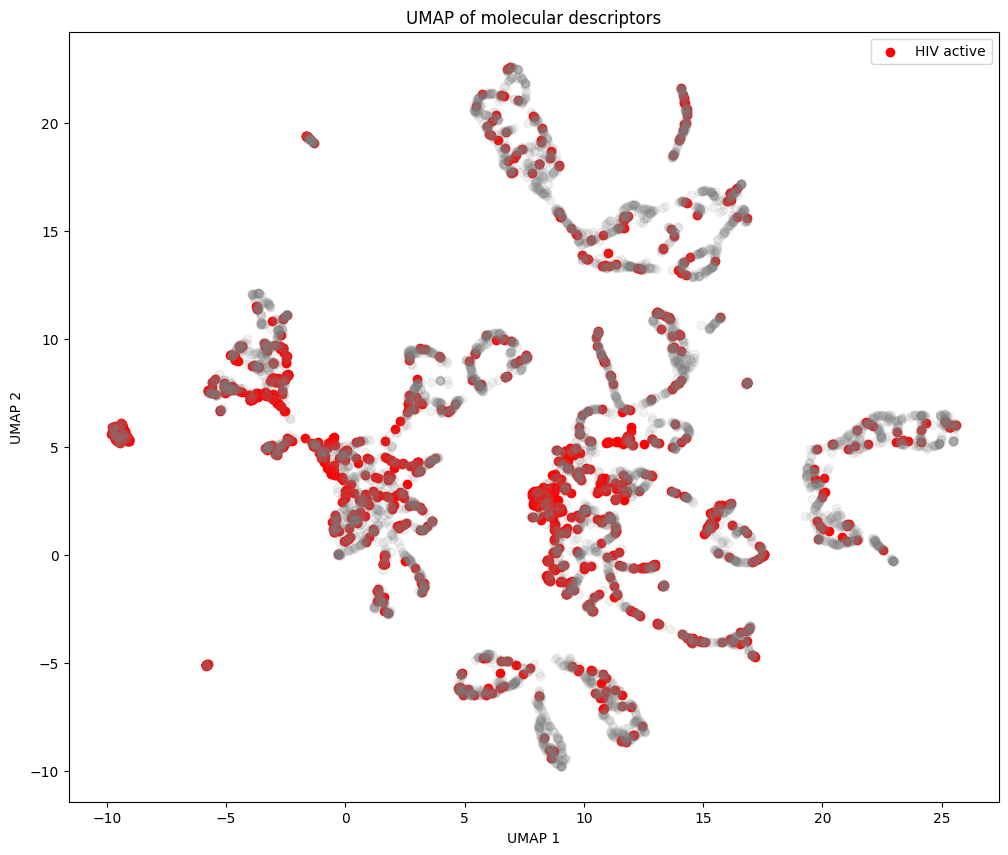

In [144]:
# plot the UMAP result and color by the activity of each data point
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
# use class 1 only
X_umap_pos = X_umap[balanced_df['HIV active']==1]
X_umap_neg = X_umap[balanced_df['HIV active']==0]
plt.scatter(X_umap_pos[:,0], X_umap_pos[:,1], alpha= 1, c='red', label='HIV active')
plt.scatter(X_umap_neg[:,0], X_umap_neg[:,1], c='grey', alpha=0.1)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.title('UMAP of molecular descriptors')
plt.show()

# Feature selection

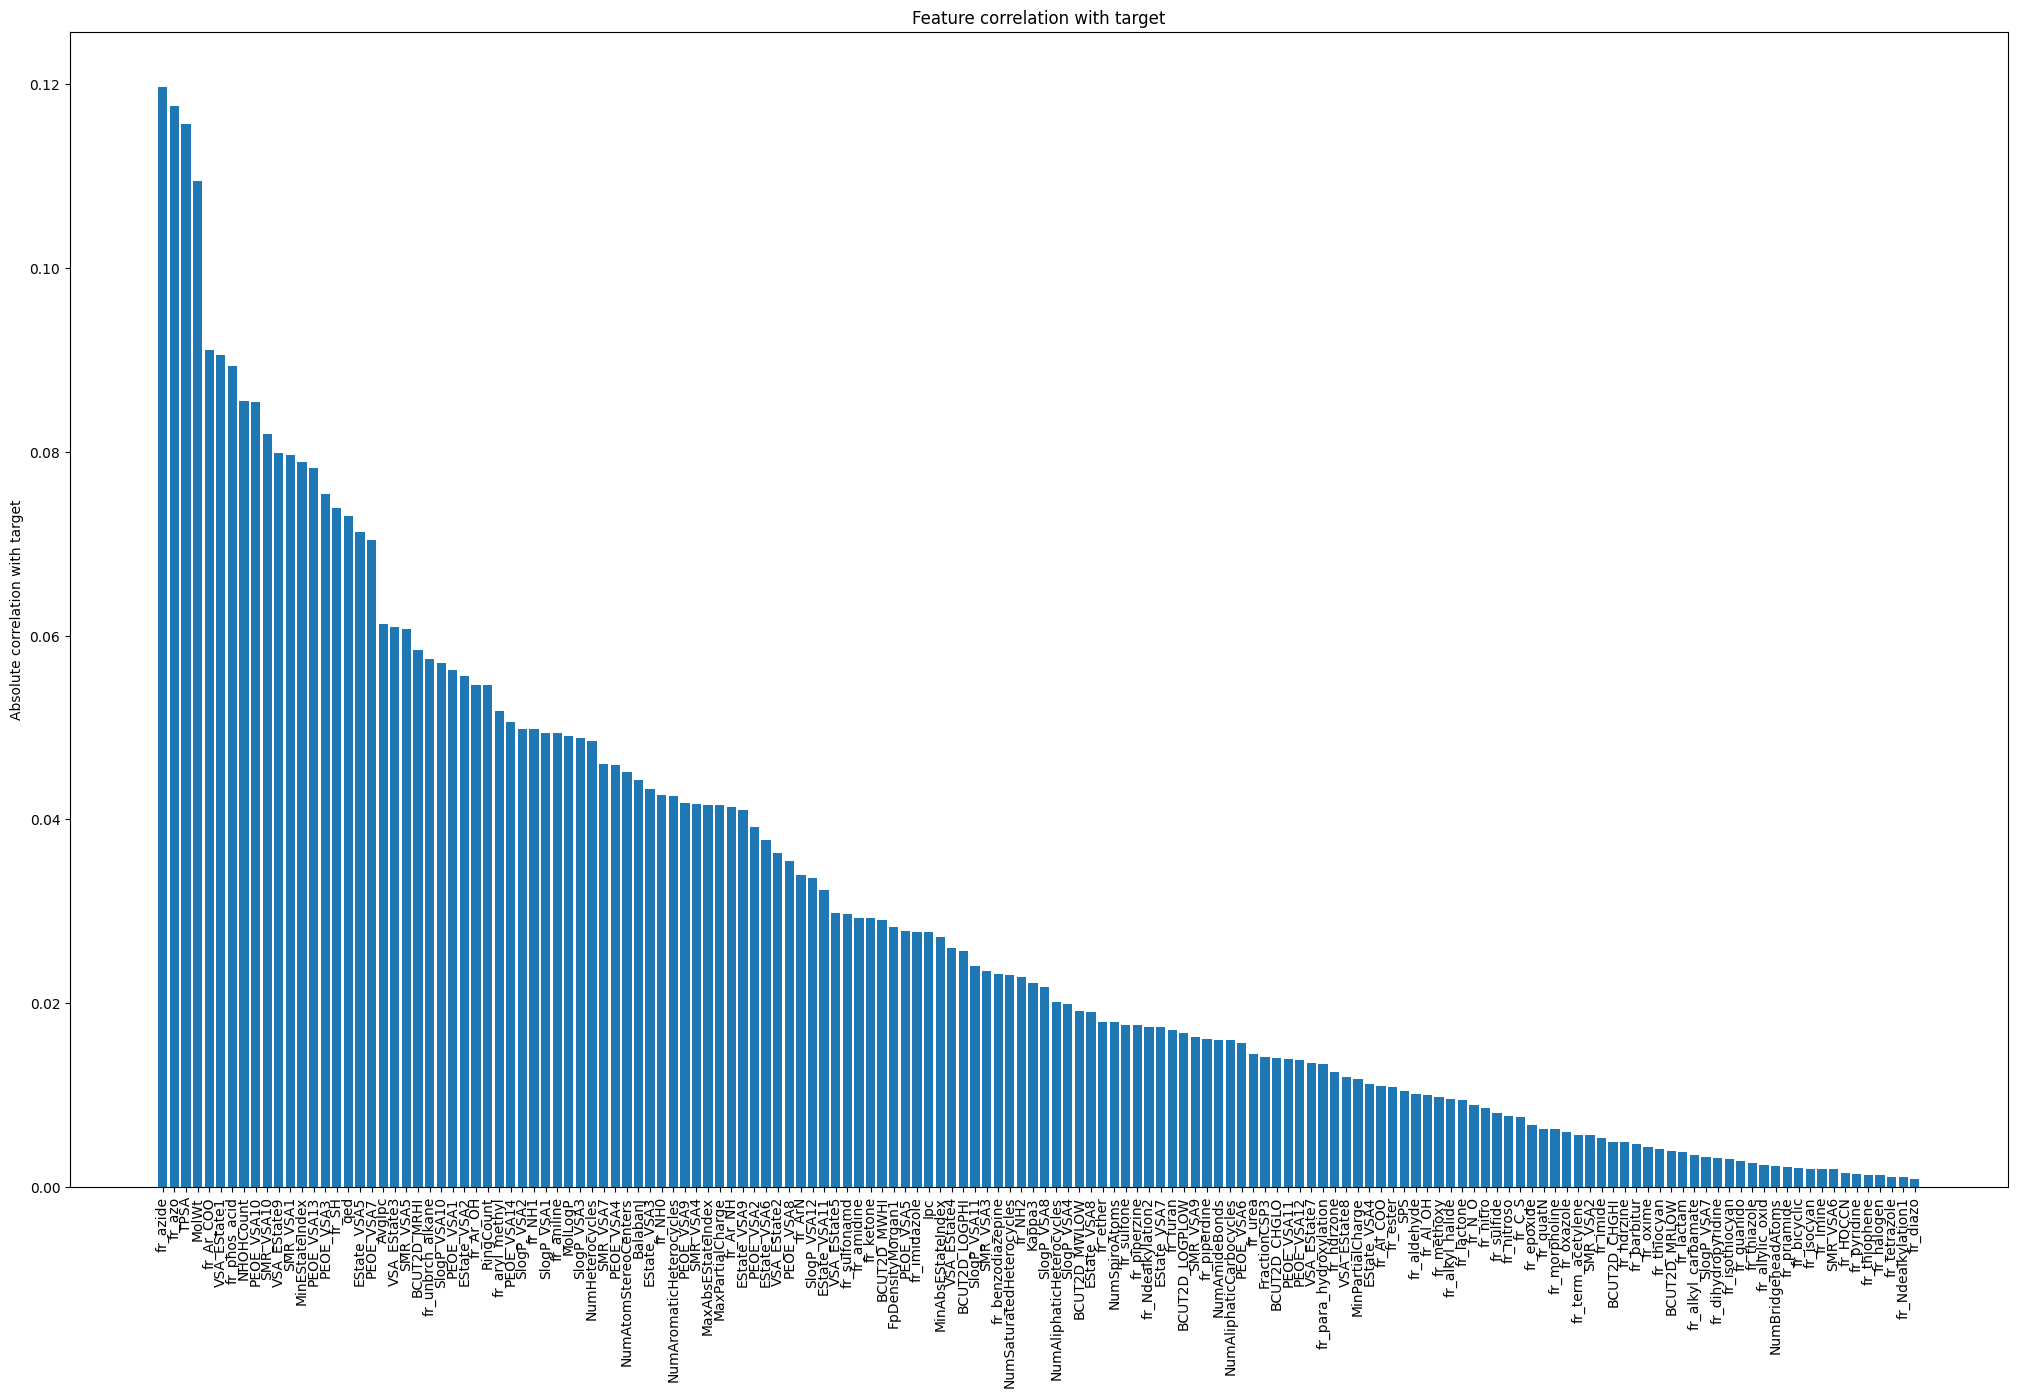

In [19]:
# plot the correlation of each feature with the target
import numpy as np
correlations = X.apply(lambda x: np.corrcoef(x, y)[0,1])
correlations = correlations.abs().sort_values(ascending=False)
plt.figure(figsize=(25,15))
plt.bar(correlations.index, correlations.values)
plt.xticks(rotation=90)
plt.ylabel('Absolute correlation with target')
plt.title('Feature correlation with target')
plt.show()

In [20]:
# 10 most correlated features with the target
corr_features = correlations.head(30)
corr_features

fr_azide            0.119721
fr_azo              0.117604
TPSA                0.115634
MolWt               0.109483
fr_Ar_COO           0.091130
VSA_EState1         0.090584
fr_phos_acid        0.089372
NHOHCount           0.085560
PEOE_VSA10          0.085393
SMR_VSA10           0.081942
VSA_EState9         0.079898
SMR_VSA1            0.079675
MinEStateIndex      0.078878
PEOE_VSA13          0.078268
PEOE_VSA3           0.075407
fr_SH               0.073926
qed                 0.072999
EState_VSA5         0.071310
PEOE_VSA7           0.070408
AvgIpc              0.061213
VSA_EState3         0.060890
SMR_VSA5            0.060683
BCUT2D_MRHI         0.058423
fr_unbrch_alkane    0.057416
SlogP_VSA10         0.056983
PEOE_VSA1           0.056293
EState_VSA2         0.055585
fr_Ar_OH            0.054664
RingCount           0.054631
fr_aryl_methyl      0.051809
dtype: float64

In [21]:
X_selected = X[corr_features.index].reset_index(drop=True)
y = y.reset_index(drop=True)
X_selected['HIV active'] = y

In [28]:
X_selected

,fr_azide,fr_azo,TPSA,MolWt,fr_Ar_COO,VSA_EState1,fr_phos_acid,NHOHCount,PEOE_VSA10,SMR_VSA10,...,SlogP_VSA2,fr_NH1,SlogP_VSA1,fr_aniline,MolLogP,SlogP_VSA3,NumHeterocycles,SMR_VSA7,PEOE_VSA4,HIV active
0,-0.075285,-0.121837,-1.014813,-0.436011,-0.131099,-0.582145,-0.060594,-0.720073,-0.810142,0.787087,...,-1.011331,-0.588811,-0.328372,2.087557,0.811094,-0.500475,-0.228957,0.291367,-0.457443,0
1,-0.075285,-0.121837,1.304390,0.041172,-0.131099,2.650434,-0.060594,1.893132,0.127752,1.004853,...,-0.263322,-0.588811,0.410913,2.087557,-0.601795,0.739729,-1.140440,-0.092132,2.085213,0
2,-0.075285,-0.121837,0.445193,-1.046894,-0.131099,2.211410,-0.060594,0.150995,-0.810142,-0.293250,...,0.166268,-0.588811,-0.879947,-0.554093,-1.721305,0.739729,-1.140440,-1.479330,2.085213,0
3,-0.075285,-0.121837,-0.564907,-0.603342,-0.131099,0.541638,-0.060594,-0.284539,-0.810142,-0.028488,...,-0.738525,0.190712,-0.307278,0.766732,0.381639,0.207745,-1.140440,-0.624447,-0.457443,0
4,-0.075285,-0.121837,-0.400299,-1.361317,5.046710,-0.582145,-0.060594,0.150995,0.273546,-1.080436,...,-0.627686,-0.588811,-0.879947,-0.554093,-0.774390,-0.885548,-1.140440,-0.608661,-0.457443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39451,-0.075285,-0.121837,-0.418791,0.096091,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,-0.156358,...,0.295630,0.190712,-0.879947,-0.554093,0.386528,-0.115401,0.682527,-0.457142,-0.457443,0
39452,-0.075285,-0.121837,-0.167504,0.730612,-0.131099,-0.026946,-0.060594,-0.284539,-0.810142,0.157446,...,-0.351058,0.190712,0.738070,0.766732,1.237629,-0.115401,1.594010,0.074067,-0.457443,0
39453,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446,...,-0.604687,0.190712,-0.328372,0.766732,1.347961,-0.115401,0.682527,0.428207,-0.457443,0
39454,-0.075285,-0.121837,-0.472284,0.464896,-0.131099,-0.582145,-0.060594,-0.284539,-0.810142,0.157446,...,-0.604687,0.190712,-0.328372,0.766732,1.347961,-0.115401,0.682527,0.428207,-0.457443,0


# Model Training

# Model Evaluation

### Report AUC curve
### find best threshold on the train set
### Report Confusion matrix, as well as precision, recall and F1 Score

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

In [ ]:
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.inspection import permutation_importance

def train_eval_model(model, X_train, y_train, X_test, y_test,
                     feature_selection=True,
                     feature_importance=True):
    """
    Train and evaluate a classification model.

        Returns: model, tpr, fpr, optimal_treshold, performance_dict
    """
    # fit using sequential feature selector
    # default: 5 fold cross-validation
    if feature_selection:
        sfs = SequentialFeatureSelector(model, n_jobs=-1, tol=0.08, direction='backward', scoring='roc_auc')
        sfs.fit(X_train, y_train)

    # refit the model using only the selected features
    if feature_selection:
        X_train = X_train[X_train.columns[sfs.get_support()]]
        X_test = X_test[X_train.columns]  # ensure test set has the same features
    model.fit(X_train, y_train)

    # get feature and importances
    if feature_importance:
        result = permutation_importance(
            model, X_test, y_test, n_repeats=4, random_state=42, n_jobs=-1,
            scoring='roc_auc'
        )
        sorted_importances_idx = result.importances_mean.argsort()
        importances = pd.DataFrame(
            result.importances[sorted_importances_idx].T,
            columns=X_train.columns[sorted_importances_idx],
        )
    else:
        importances = None
    
    # get train threshold, that gives best F1 score
    y_train_prob = model.predict_proba(X_train)[:,1]
    fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_prob)
    optimal_idx = np.argmax(tpr_train - fpr_train)
    optimal_threshold = thresholds[optimal_idx]

    # evaluate on test set
    y_test_prob = model.predict_proba(X_test)[:,1]
    y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

    # get precision, recall, f1-score
    report = classification_report(y_test, y_test_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
    # round the values in confusion matrix to 2 decimal places
    conf_matrix = np.round(conf_matrix, 2)
    auc = roc_auc_score(y_test, y_test_prob)
    performance_dict = {
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score'],
        'auc': auc,
        'confusion_matrix': conf_matrix
    }

    fpr, tpr, _ = roc_curve(y_test, y_test_prob)

    return model, tpr, fpr, optimal_threshold, performance_dict, importances

In [32]:
def plot_model_results(idx, axes, model_name, tpr, fpr, performance_dict, importances):
    """
    Plot ROC curve, confusion matrix and print performance metrics.

        Parameters:
            idx: index of the model (for subplotting)
            axes: matplotlib axes array
            model_name: name of the model
            tpr: true positive rate
            fpr: false positive rate
            performance_dict: dictionary with precision, recall, f1-score, auc, confusion_matrix
    """

    # plot ROC curve
    axes[idx, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {performance_dict["auc"]:.2f})')
    axes[idx, 0].plot([0, 1], [0, 1], 'k--')
    axes[idx, 0].set_xlabel('False Positive Rate')
    axes[idx, 0].set_ylabel('True Positive Rate')
    axes[idx, 0].set_title(f'ROC Curve - {model_name}')
    axes[idx, 0].legend(loc='lower right')

    # plot confusion matrix
    axes[idx, 1].imshow(performance_dict['confusion_matrix'], cmap='Blues')
    axes[idx, 1].set_xticks([0, 1])
    axes[idx, 1].set_yticks([0, 1])
    axes[idx, 1].set_xticklabels(['Predicted 0', 'Predicted 1'])
    axes[idx, 1].set_yticklabels(['Actual 0', 'Actual 1'])
    axes[idx, 1].set_title(f'Confusion Matrix - {model_name}: Prec / Rec / F1: {performance_dict["precision"]:.2f} / {performance_dict["recall"]:.2f} / {performance_dict["f1-score"]:.2f}')
    
    # plot bar plot of feature importances
    importances_mean = importances.mean().sort_values(ascending=False)
    importances_std = importances.std().sort_values(ascending=False)
    axes[idx, 2].bar(importances_mean.index, importances_mean.values, color='skyblue')
    # rotate x_labels by 90 degrees
    axes[idx, 2].tick_params(axis='x', rotation=90)
    axes[idx, 2].errorbar(importances_mean.index, importances_mean.values, yerr=importances_std.values, fmt='o', color='black', capsize=5)
    axes[idx, 2].set_title(f'Feature Importances - {model_name}')
    axes[idx, 2].set_ylabel('Permutation Importance (roc_auc)')
    axes[idx, 2].set_xlabel('Features')

    # Add text annotations to confusion matrix
    for i in range(2):
        for j in range(2):
            axes[idx, 1].text(j, i, performance_dict['confusion_matrix'][i, j], 
                             ha='center', va='center', color='white' if performance_dict['confusion_matrix'][i, j] > performance_dict['confusion_matrix'].max()/2 else 'black')

    return axes

In [33]:
def plot_repeated_model_results(idx, axes, model_name, tpr_list, fpr_list, performance_dict, importances_list):
    """
    Plot ROC curve, confusion matrix and print performance metrics.

        Parameters:
            idx: index of the model (for subplotting)
            axes: matplotlib axes array
            model_name: name of the model
            tpr: true positive rate
            fpr: false positive rate
            performance_dict: dictionary with precision, recall, f1-score, auc, confusion_matrix
    """

# plot ROC curve
    interp_len = 100
    for i in range(5):
        # interpolate 
        tpr_interp = np.interp(np.linspace(0, 1, interp_len), fpr_list[i], tpr_list[i])
        fpr_interp = np.linspace(0, 1, interp_len)
        # ROC AUC 
        roc_auc = auc(tpr_interp, fpr_interp)
        axes[idx, 0].plot(fpr_interp, tpr_interp, label=f'run {i+1} (AUC {roc_auc})', alpha=0.7, color='gray')
    axes[idx, 0].plot([0, 1], [0, 1], 'k--')
    axes[idx, 0].set_xlabel('False Positive Rate')
    axes[idx, 0].set_ylabel('True Positive Rate')
    axes[idx, 0].set_title(f'ROC Curve - {model_name}')
    axes[idx, 0].legend(loc='lower right')

    # plot bar plot of feature importances
    means = []
    for importances in importances_list:
        importances_mean = importances.mean().sort_values(ascending=False)

        means.append(importances_mean)
    importances_mean = pd.concat(means, axis=1).mean(axis=1).sort_values(ascending=False)
    importances_std = pd.concat(means, axis=1).std(axis=1).sort_values(ascending=False)
    axes[idx, 1].bar(importances_mean.index, importances_mean.values, color='skyblue')

    # rotate x_labels by 90 degrees
    axes[idx, 1].tick_params(axis='x', rotation=90)
    axes[idx, 1].errorbar(importances_mean.index, importances_mean.values, yerr=importances_std.values, fmt='o', color='black', capsize=5)
    axes[idx, 1].set_title(f'Feature Importances - {model_name}')
    axes[idx, 1].set_ylabel('Permutation Importance (roc_auc) as mean over 5 runs')
    axes[idx, 1].set_xlabel('Features')

    return axes

In [40]:
# construct a logistic regression model to predict HIV_active based on functional group counts

# randomly subsample the majority class to balance the dataset
min_size = y.value_counts().min() 
factor = 4
print('Size of class 1: ', min_size)
balanced_df = pd.concat([
    X_selected[X_selected['HIV active'] == 0].sample(min_size*factor, random_state=42, replace=True),
    X_selected[X_selected['HIV active'] == 1].sample(min_size, random_state=42)
])


X_ = balanced_df.drop(columns=['HIV active'])
y_ = balanced_df['HIV active']


Size of class 1:  1260


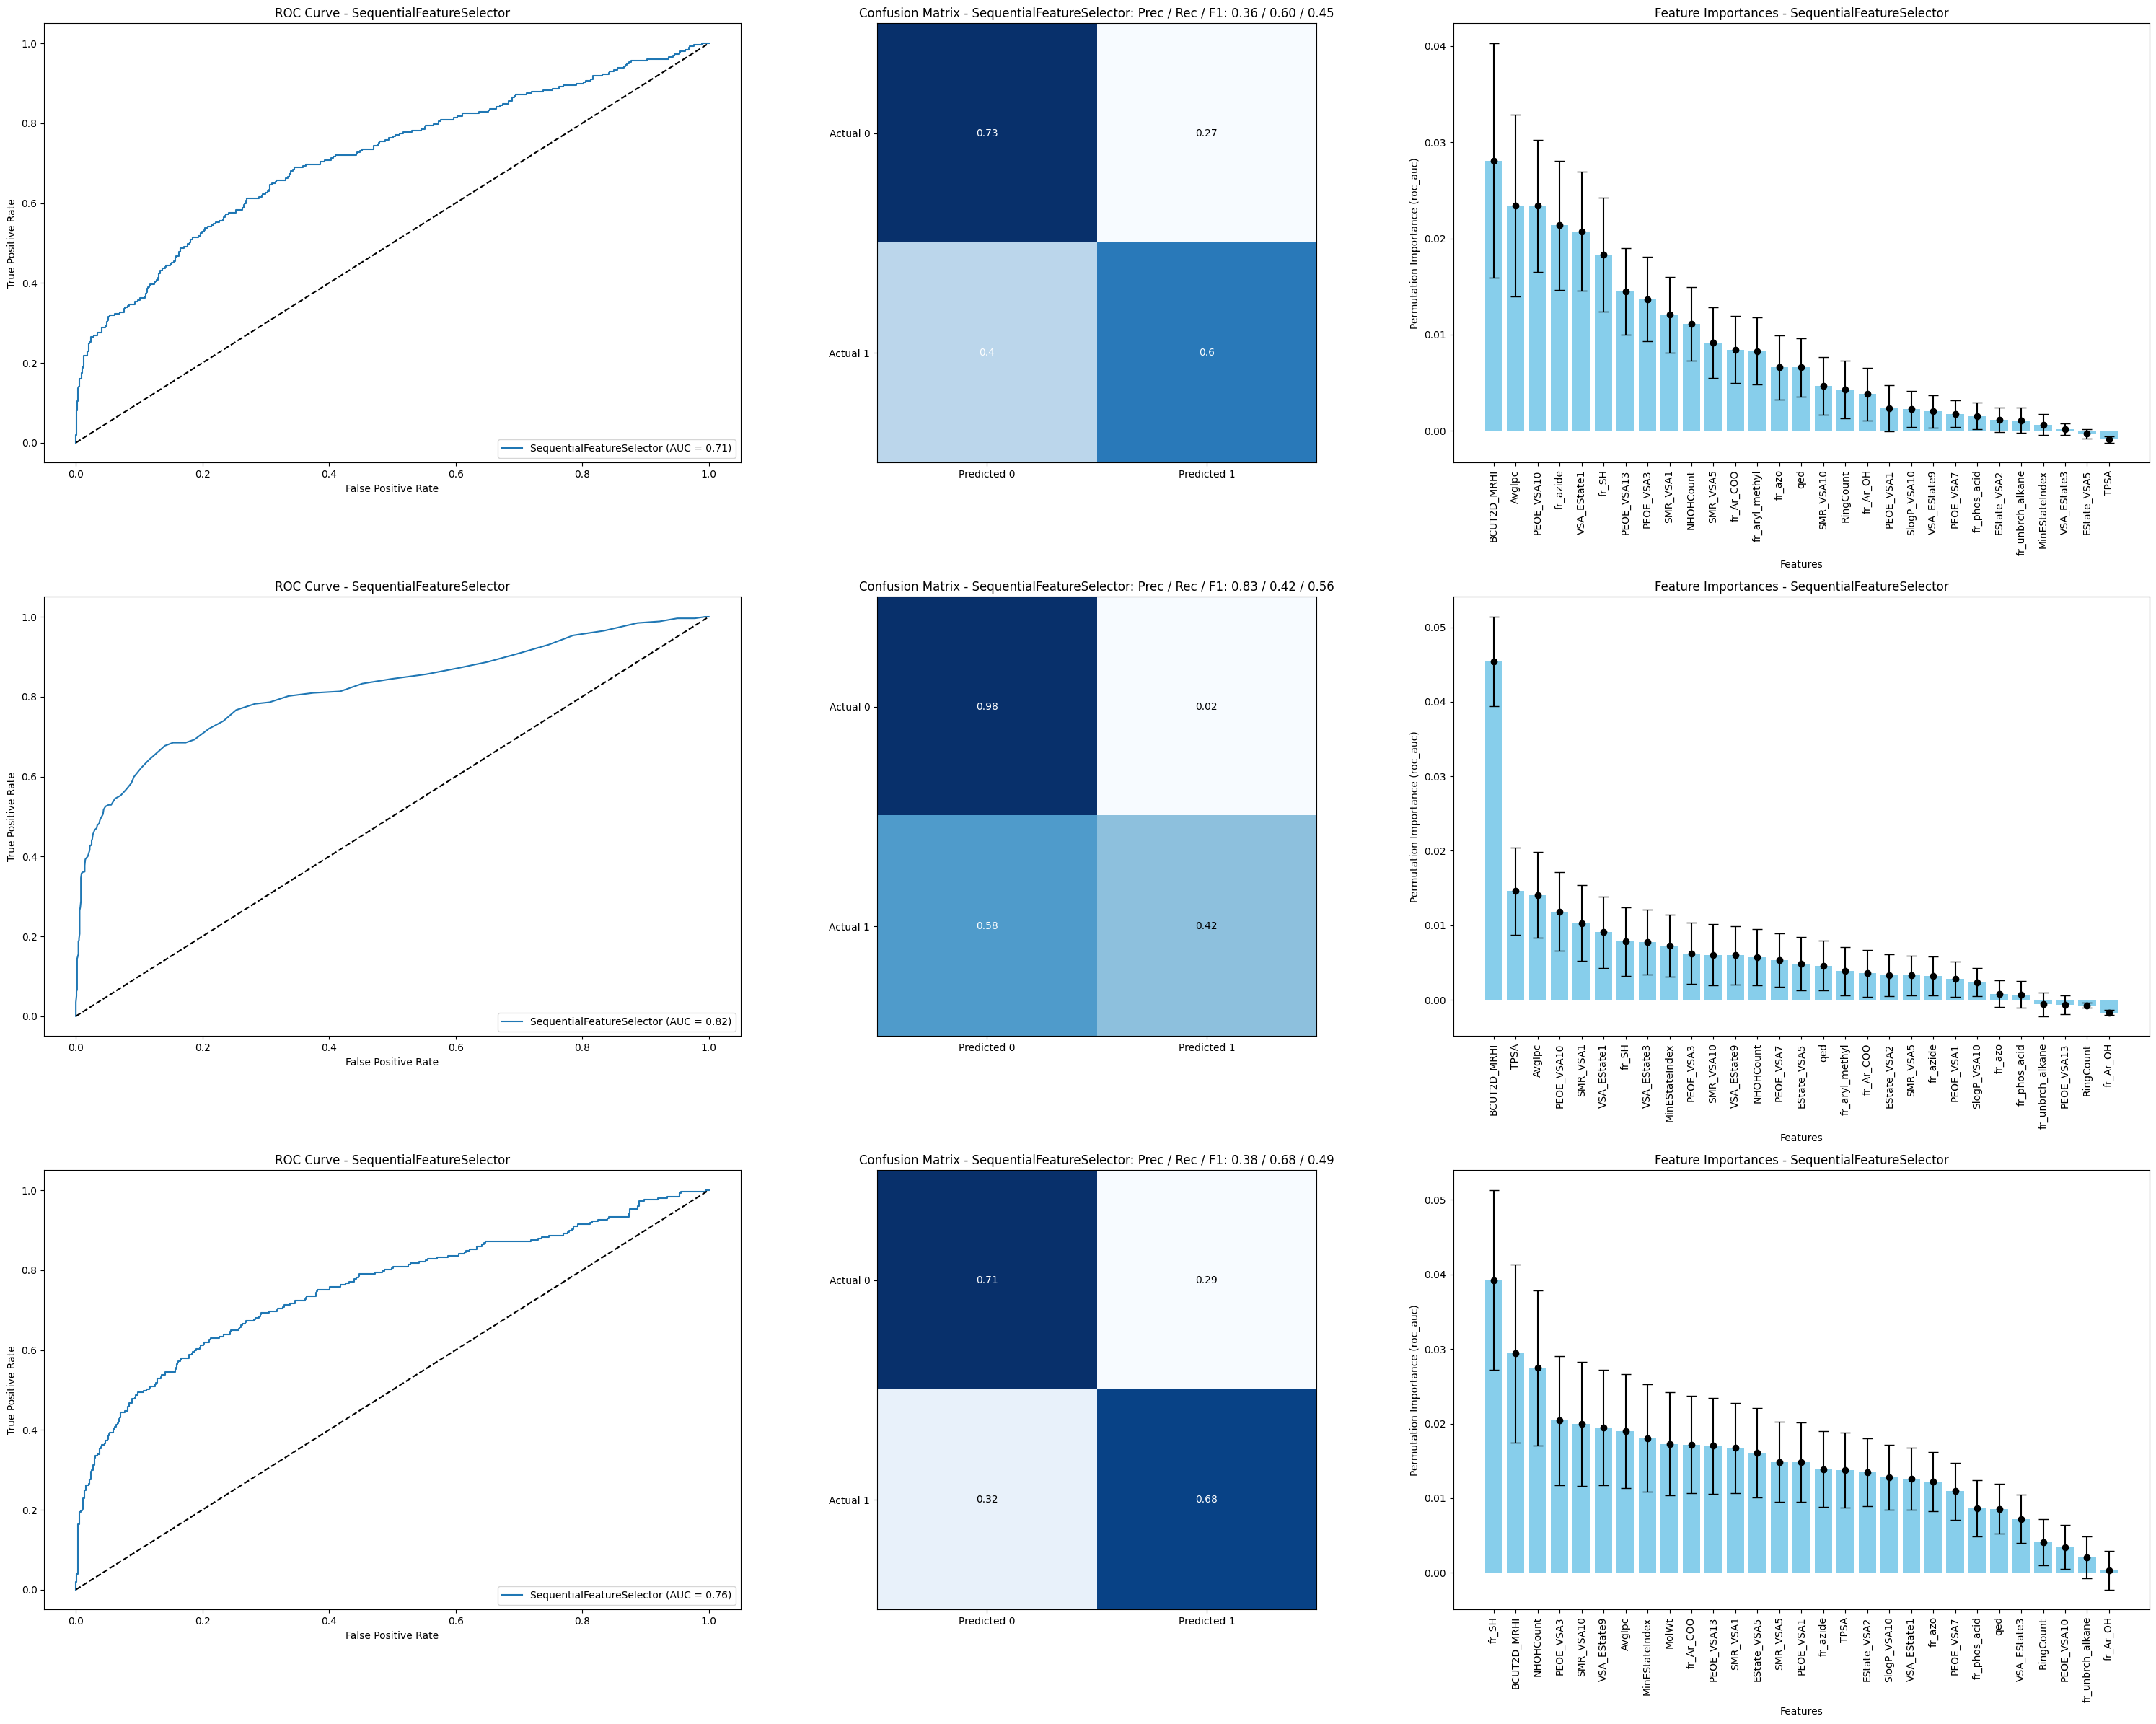

In [41]:
# run logistic regression and random forest models

models = [
    LogisticRegression(max_iter=100),  
    RandomForestClassifier(random_state=42),
    SVC(probability=True, random_state=42)
    ]

for i, model in enumerate(models):
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
    model, tpr, fpr, optimal_threshold, performance_dict, importances = train_eval_model(model, X_train, y_train, X_test, y_test)
    if i == 0:
        fig, axes = plt.subplots(len(models), 3, figsize=(30, 8 * len(models)))
    plot = plot_model_results(i, axes, model.__class__.__name__, tpr, fpr, performance_dict, importances)
    if i == len(models) - 1:
        plt.tight_layout()
        plt.show()


## Robustness Analysis via Repeated Data Splitting

To assess the robustness of our models and the stability of feature importance, we conducted an experiment where the training and evaluation process was repeated across multiple random splits of the dataset. The key aspect of this approach is the random subsampling of the majority (negative) class, which is highly overrepresented in our data. By generating different balanced subsets for each run, we ensure that the models are exposed to diverse examples from the negative class.

### Rationale

- **Class Imbalance:** The dataset contains far more negative samples than positive ones. To avoid bias and overfitting, we balance the data by randomly selecting an equal number of negative and positive samples for each run.
- **Robustness:** Training on different subsets allows us to observe how sensitive the models are to the specific composition of the training data, especially the negative class.
- **Feature Importance Stability:** By comparing feature importances across runs, we can identify which molecular descriptors consistently contribute to model performance and which are more variable.

### Experimental Procedure

1. **Repeated Subsampling:** For each model, we perform five independent runs. In each run, we randomly subsample the negative class to match the size of the positive class, creating a balanced dataset.
2. **Model Training:** The selected models (Logistic Regression, Random Forest, SVC) are trained and evaluated on each split.
3. **Performance Evaluation:** Metrics such as ROC curves, AUC, precision, recall, and F1-score are recorded for each run.
4. **Feature Importance Aggregation:** Permutation importance is calculated for each run, and the mean and standard deviation across runs are reported.

### Insights

This approach provides a more reliable estimate of model generalizability and highlights features that are robust predictors of HIV activity, regardless of the specific negative samples included. It also helps identify features whose importance is sensitive to data splits, informing future feature selection and model development strategies.

Run 1 - Model LogisticRegression
Run 2 - Model LogisticRegression
Run 3 - Model LogisticRegression
Run 4 - Model LogisticRegression
Run 5 - Model LogisticRegression
Run 1 - Model RandomForestClassifier
Run 2 - Model RandomForestClassifier
Run 3 - Model RandomForestClassifier
Run 4 - Model RandomForestClassifier
Run 5 - Model RandomForestClassifier
Run 1 - Model SVC
Run 2 - Model SVC
Run 3 - Model SVC
Run 4 - Model SVC
Run 5 - Model SVC


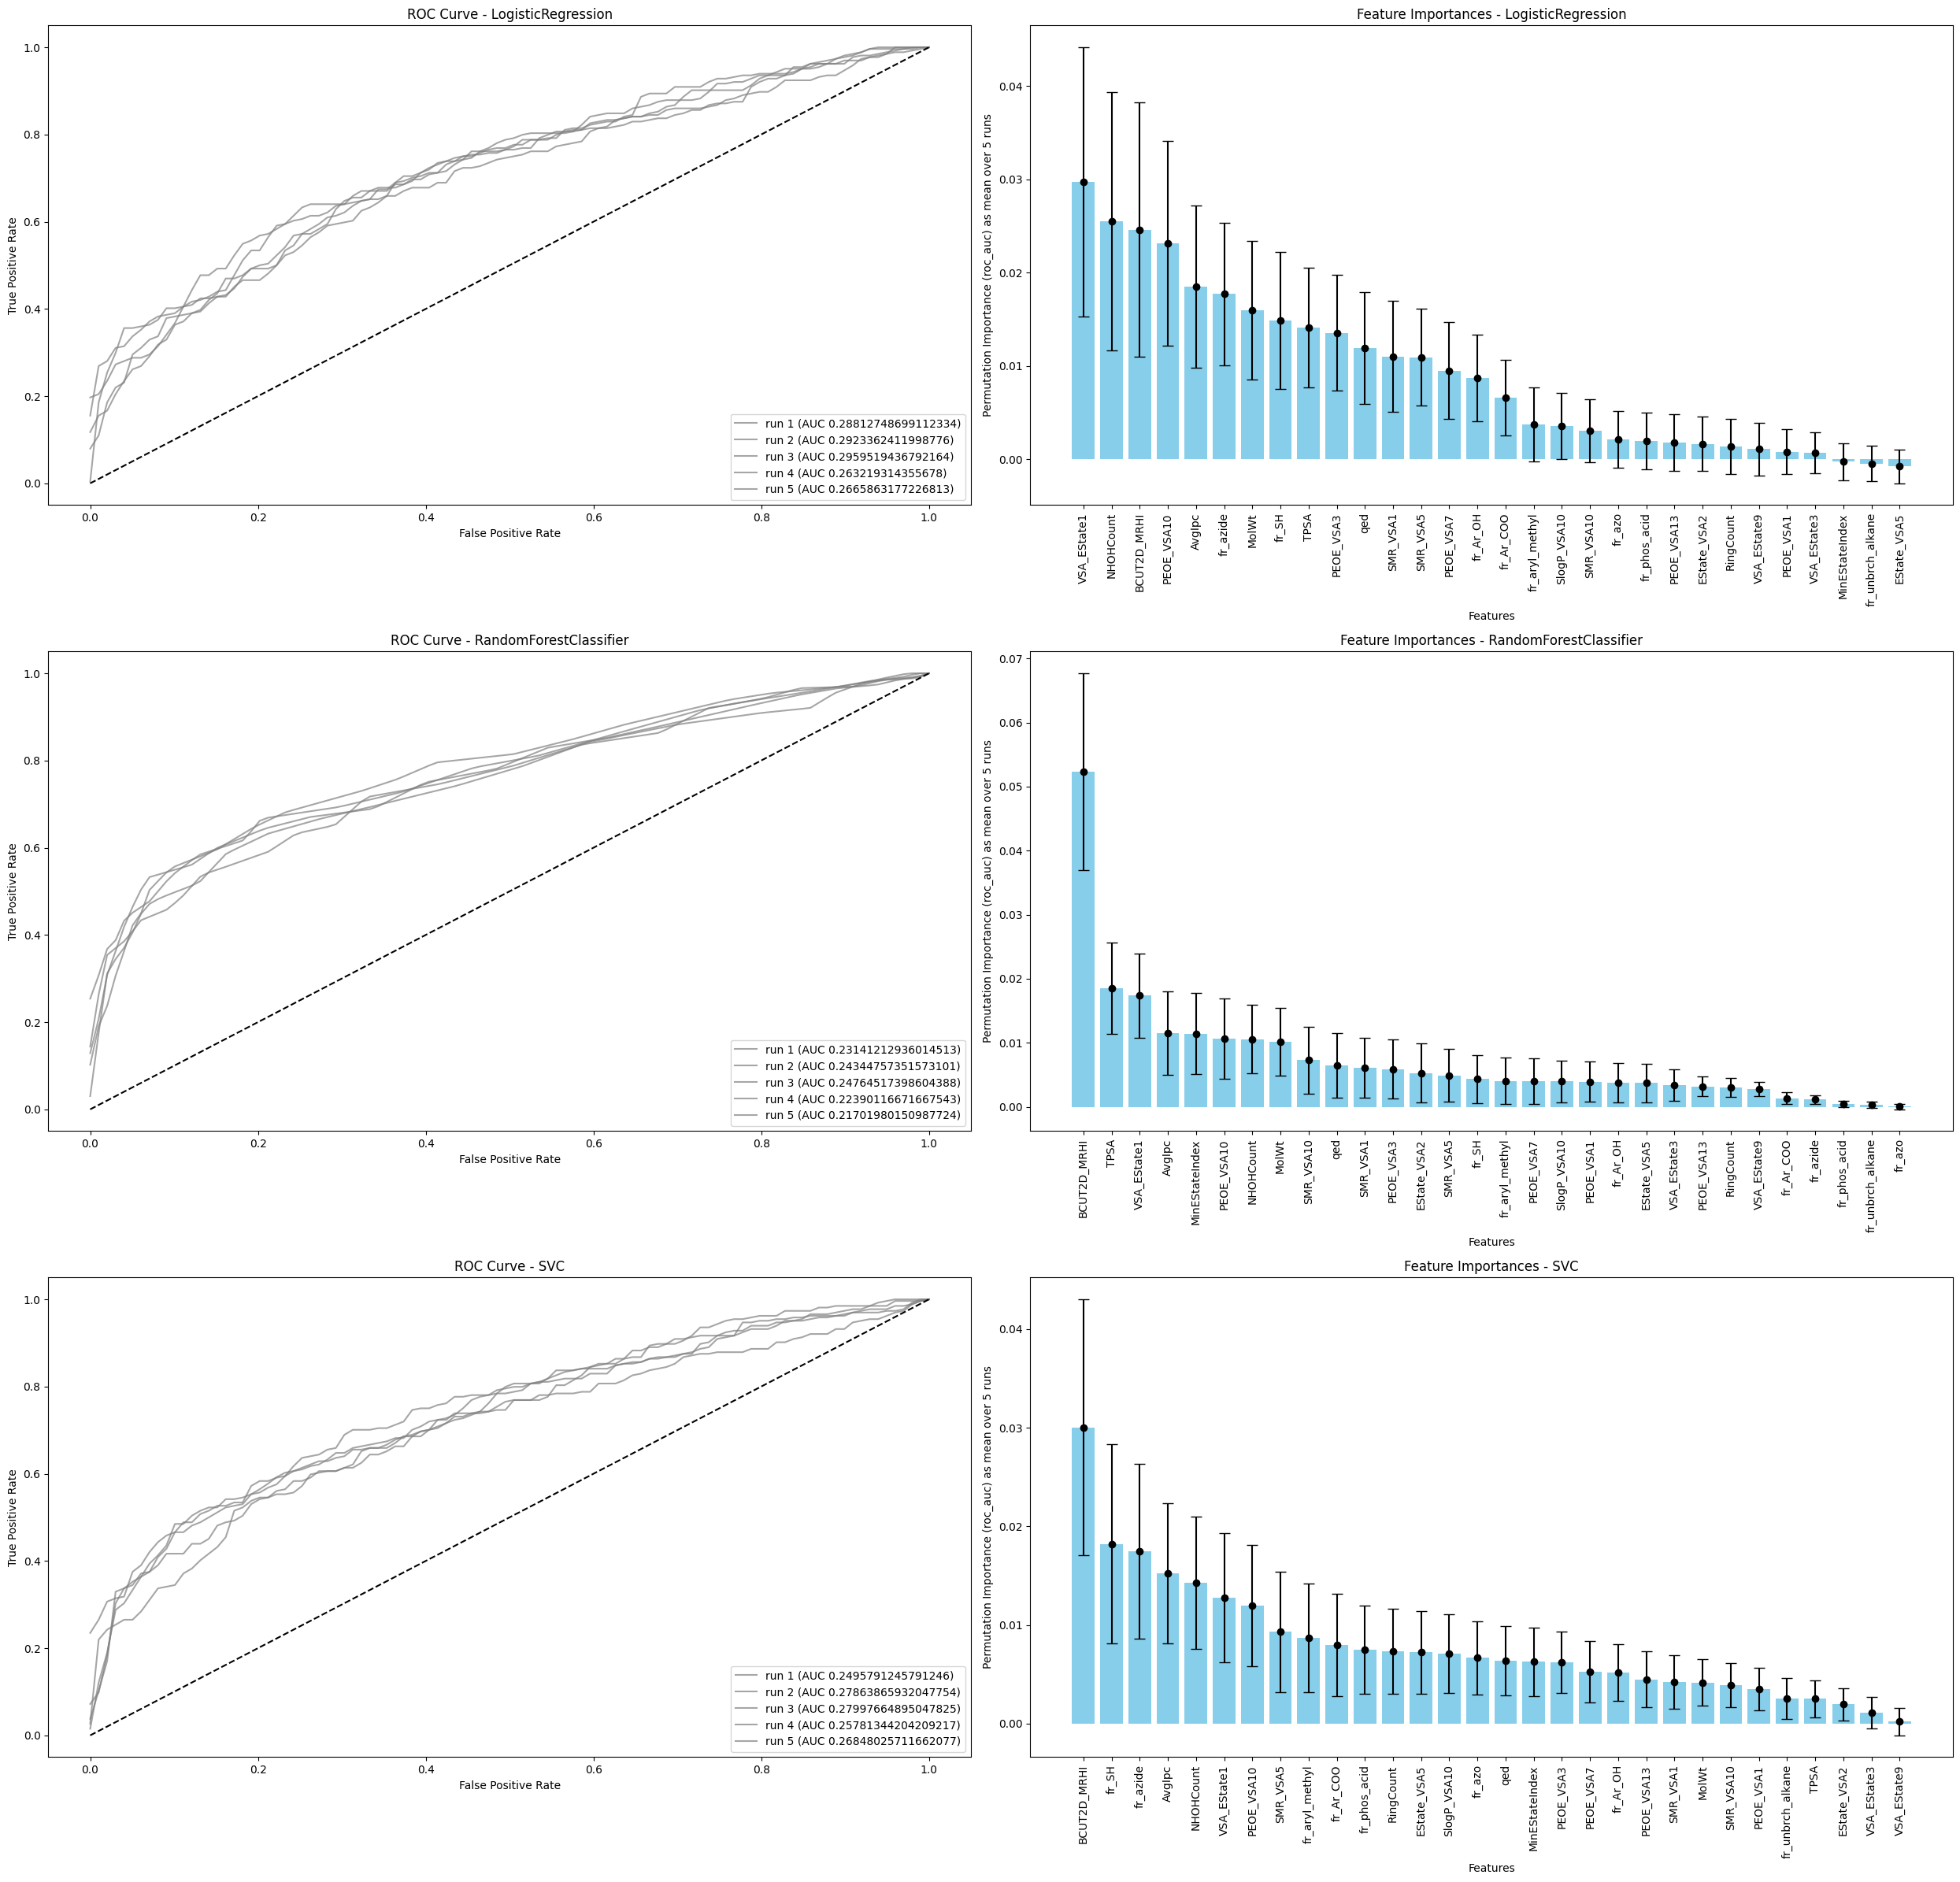

In [ ]:
fig, axes = plt.subplots(len(models), 2, figsize=(20, 8 * len(models)))
for i, model in enumerate(models):
    tpr_list = []
    fpr_list = []
    performance_list = []
    importances_list = []

    for n in range(5):  # 5 different random states for balancing
        min_size = y.value_counts().min() 
        balanced_df = pd.concat([
            X_selected[X_selected['HIV active'] == 0].sample(min_size),
            X_selected[X_selected['HIV active'] == 1].sample(min_size)
        ])


        X_ = balanced_df.drop(columns=['HIV active'])
        y_ = balanced_df['HIV active']
        
        print(f'Run {n+1} - Model {model.__class__.__name__}')
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
        _, tpr, fpr, optimal_threshold, performance_dict, importances = train_eval_model(model, X_train, y_train, X_test, y_test)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
        performance_list.append(performance_dict)
        importances_list.append(importances)

    # aggregate results

    plot = plot_repeated_model_results(i, axes, model.__class__.__name__, tpr_list, fpr_list, performance_dict, importances_list)
plt.tight_layout()
plt.show()

Class imbalance factor: 1, Model: LogisticRegression, ROC AUC: 0.7244002525252525
Class imbalance factor: 1, Model: RandomForestClassifier, ROC AUC: 0.7872395833333332
Class imbalance factor: 1, Model: SVC, ROC AUC: 0.7559738005050504
Class imbalance factor: 2, Model: LogisticRegression, ROC AUC: 0.7038619753185033
Class imbalance factor: 2, Model: RandomForestClassifier, ROC AUC: 0.8243899516753865
Class imbalance factor: 2, Model: SVC, ROC AUC: 0.764271736091697
Class imbalance factor: 3, Model: LogisticRegression, ROC AUC: 0.7170677087907262
Class imbalance factor: 3, Model: RandomForestClassifier, ROC AUC: 0.8032432818125933
Class imbalance factor: 3, Model: SVC, ROC AUC: 0.7412564766839378
Class imbalance factor: 4, Model: LogisticRegression, ROC AUC: 0.7248022469556312
Class imbalance factor: 4, Model: RandomForestClassifier, ROC AUC: 0.8352277796959318
Class imbalance factor: 4, Model: SVC, ROC AUC: 0.7574901753882323
Class imbalance factor: 5, Model: LogisticRegression, ROC AUC

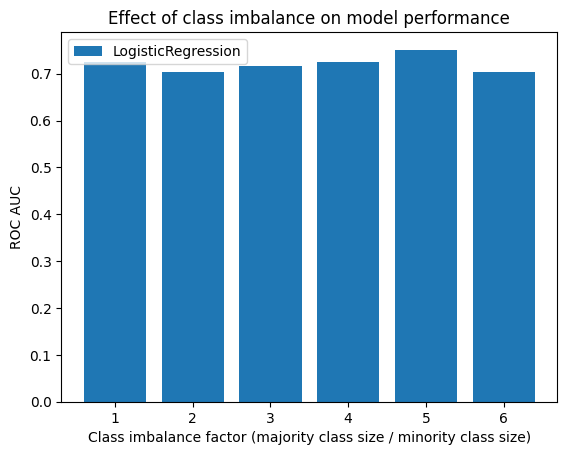

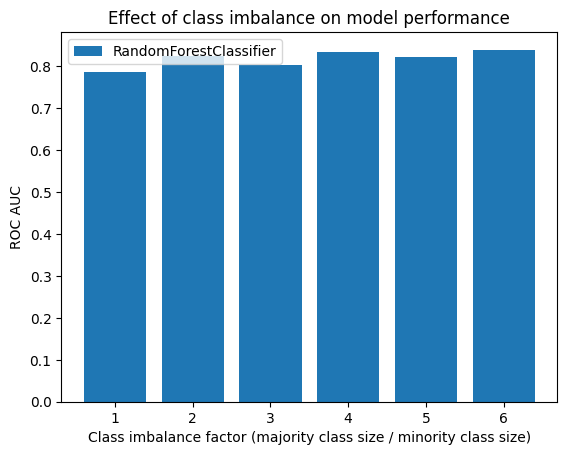

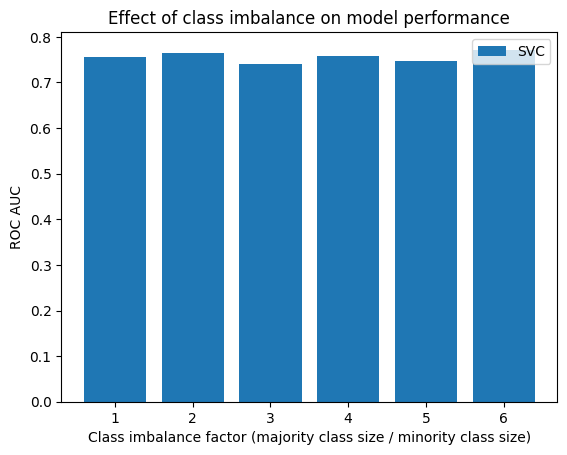

In [39]:
# for different magnitudes of class imbalance
factors = [1, 2, 3, 4, 5, 6]
model_roc_auc = {model.__class__.__name__: [] for model in models}
for factor in factors:
    min_size = y.value_counts().min() 
    balanced_df = pd.concat([
        X_selected[X_selected['HIV active'] == 0].sample(min_size*factor, replace=True),
        X_selected[X_selected['HIV active'] == 1].sample(min_size)
    ])

    for i, model in enumerate(models):
        X_ = balanced_df.drop(columns=['HIV active'])
        y_ = balanced_df['HIV active']
        
        X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
        _, _, _, _, performance_dict, _ = train_eval_model(model, X_train, y_train, X_test, y_test)
        roc_auc = performance_dict['auc']
        print(f'Class imbalance factor: {factor}, Model: {model.__class__.__name__}, ROC AUC: {roc_auc}')
        model_roc_auc[model.__class__.__name__].append(roc_auc)

# plot the results
for model_name, roc_auc_list in model_roc_auc.items():
    plt.bar(factors, roc_auc_list, label=model_name)
    plt.xlabel('Class imbalance factor (majority class size / minority class size)')
    plt.ylabel('ROC AUC')
    plt.title('Effect of class imbalance on model performance')
    plt.legend()
    plt.show()

In [ ]:
# see different folds of oversampling
# use morgan fingerprints instead of descriptors